In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from urllib.request import Request, urlopen
import datetime
import string
from string import digits
import collections
import scipy.stats as scs
import cc_pipeline as P
import time
import random
import pickle

#sentiment and language
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import spacy
import vaderSentiment
from langdetect import detect
from gensim.models import Word2Vec
from gensim import corpora
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.decomposition import PCA, KernelPCA
from sklearn.pipeline import Pipeline
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF, LatentDirichletAllocation
from gensim.models.ldamodel import LdaModel
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import chi2
import knee_locator

#plotting
from bokeh.plotting import figure, show, output_file, output_notebook, ColumnDataSource
from bokeh.models import HoverTool, BoxSelectTool
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
import pyLDAvis.sklearn
import pyLDAvis.gensim as gensimvis
import pyLDAvis

nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:

def scrape_text(series):
    
    #use pd.series instead moving forward
    text = []
    for link in series:
        
        try:
            req = Request(link, headers={'User-Agent': 'Mozilla/5.0'})
            webpage = urlopen(req).read()
            webpage = webpage.decode('utf-8')
            text.append(webpage)
        except SocketError as e:
            if e.errno != errno.ECONNRESET:
                raise # Not error we are looking for
            pass # Handle error here.
        
    return text

def scrape_from_url(cycles):
    
    for i in range(cycles):
        
        time.sleep(900)
        
        from_df = pd.read_csv('data/cc_recent.csv', encoding='utf-8')
        temp_df = from_df.head(1000)

        #scrape text then concat
        text_url_series = pd.Series(temp_df['url'])
        extracts = scrape_text(text_url_series)
        extracts = pd.Series(extracts)
        temp_df['text'] = extracts

        head_df = pd.read_csv('data/cc_head_text.csv', encoding='utf-8')
        head_df = pd.concat([head_df, temp_df])
        head_df.to_csv('data/cc_head_text.csv', encoding='utf-8', index=False)

        from_df = from_df.drop(from_df.index[0:1000])
        from_df.to_csv('data/cc_recent.csv', encoding='utf-8', index=False)

        head_df=None
        temp_df=None
        from_df=None
        text_url_series=None
        extracts=None
        


In [ ]:
#scrape_from_url(1)

In [ ]:
#clean text

def get_show_text(show_raw):
    
    '''returns show text without timestamps'''
    
    return "\n".join( ["\n".join( x.split("\n")[2:] ) for x in show_raw.split("\n\n")] )



def clean_all_text(text_list):
    
    '''cleans all text and creates new column in dataframe'''
    
    doc_list = []
    for word in text_list:
        doc_list.append(get_show_text(word))
    return doc_list


def clean_text(doc):
    '''cleans and lemmatizes a string by removing punc, characters, digits, and len(words) < 3'''
    
    stop_words = stopwords.words('english')
    punct = ('!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~♪¿’')
    remove_digits = str.maketrans('', '', digits)
    wordnet_lemmatizer = WordNetLemmatizer()
    lemmatized = []
    
    doc = doc.split('\n')
    doc = ' '.join(doc)
    doc = doc.split('-')
    doc = ' '.join(doc)
    doc = doc.split('...')
    doc = ' '.join(doc)
    doc = word_tokenize(doc)

    a = [char for char in doc if char not in punct]
    b = [w for w in a if w not in stop_words] 
    c = [w for w in b if len(w) > 3]
    d = [x for x in c if not (x.isdigit() or x[0] == '-' and x[1:].isdigit())]

    e = ' '.join(d)
    f = e.lower()
    g = f.translate(remove_digits)
    cleaned = str(g)
    doc = word_tokenize(cleaned)
    
    for val in doc:
        doc_temp = wordnet_lemmatizer.lemmatize(val)
        lemmatized.append(doc_temp)
    doc = ' '.join(lemmatized)
    
    return doc

def clean_and_return(docs_list):
    
    docs = []
    for cc in docs_list:
        cleaned_temp = clean_text(cc)
        docs.append(cleaned_temp)
        
    return docs


def lang_detect(doc_series):
    
    lang = []
    for x in doc_series:
        eng = 'en'
        span = 'es'

        try:
            if detect(x) == eng:
                lang.append(eng)
            else:
                lang.append(span)
        except:
            lang.append(None)
            
    return lang

In [ ]:
temp_df = pd.read_csv('data/cc_1000_text.csv', encoding='utf-8')
temp_df.describe()


In [ ]:

temp = temp_df['text'].values
temp = temp.tolist()
type(temp)



In [ ]:
docs_list = clean_all_text(temp)
type(docs_list)




In [ ]:
cleaned_list = clean_and_return(docs_list)


In [ ]:
temp_df['cleaned'] = cleaned_list
temp_df.head(1)

In [ ]:
doc_series = pd.Series(temp_df['cleaned'].values)
language = lang_detect(doc_series)
temp_df['language'] = language
english = temp_df[temp_df['language'] == 'en']
spanish = temp_df[temp_df['language'] == 'es']



## Text Analysis

In [31]:
english = pd.read_csv('data/testenglish.csv', encoding='utf-8')
#english.to_csv('data/testenglish.csv', encoding='utf-8', index=False)
#spanish.to_csv('data/testspanish.csv', encoding='utf-8', index=False)
english.head(1)

,_id,channel,created_at,duration,lang,machine_id,ts,tui,tv,url,zip_url,date,text,cleaned,language
0,{'$oid': '5bb2b5082c1ba60007fc013d'},WBNX_HD_CW,{'$date': '2018-10-02T00:00:08.982Z'},900000,dflt,ENSWERCCR7_8_3,{'$numberLong': '1538437500000'},251536767,{'$date': '2018-10-01T23:45:00.000Z'},https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,2018-10-02 00:00:08.982,1538437621406\n1835\n[ KNOCK ON DOOR ]\n\n1538...,knock door knew only that still knock have doo...,en


In [32]:
text = english['cleaned'].values
text = text.tolist()
type(text)

list

In [4]:
def vectorize_text(doc_list):
    
    vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'), ngram_range=(1, 3), lowercase=True) 
    tfidf_model = vectorizer.fit_transform(doc_list)
    
    return tfidf_model

    
def svd(doc_list):
    
    model = vectorize_text(doc_list)
    
    svd = TruncatedSVD(n_components=100, n_iter=7, random_state=42)
    clf = svd.fit_transform(model) 
    
    return clf

def find_elbow(doc_list):
    
    clf = svd(doc_list)
    
    distortions = []
    K = range(1,10)
    for k in K:
        kmeanModel = KMeans(n_clusters=k, n_jobs=2)
        kmeanModel.fit(clf)
        distortions.append(sum(np.min(cdist(clf, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / clf.shape[0])

    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

def KMeans_PCA_plot(doc_list, num_clusters=3, n_jobs=4):
    
    clf = svd(doc_list)
    
    km = KMeans(n_clusters=num_clusters, n_jobs=4) 
    km.fit(clf)

    clusters = km.labels_.tolist()

    pca = PCA(n_components=2).fit(clf)
    data2D = pca.transform(clf)
    plt.scatter(data2D[:,0], data2D[:,1], c=clusters, alpha=0.1)

    centers2D = pca.transform(km.cluster_centers_)

    plt.scatter(centers2D[:,0], centers2D[:,1], 
                marker='x', s=200, linewidths=3, c='r')
    plt.title('(SVD REDUCED) Kmeans Clusters')
    plt.show() 

## TFIDF - Kernel PCA

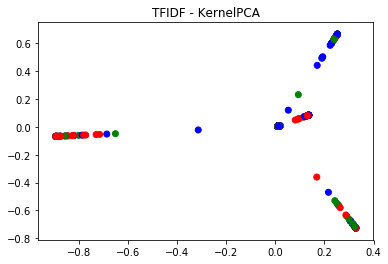

In [43]:
tfidf_model = vectorize_text(text)

kpca = KernelPCA(n_components=5, kernel='rbf', gamma=15)
X_kpca = kpca.fit_transform(tfidf_model)


plt.figure()
plt.title('TFIDF - KernelPCA')
plt.scatter(X_kpca[:, 0], X_kpca[:, 1], c='rgb')
plt.show()

In [ ]:
X_kpca.shape #n_samples, n_components(clusters)

## Linear PCA

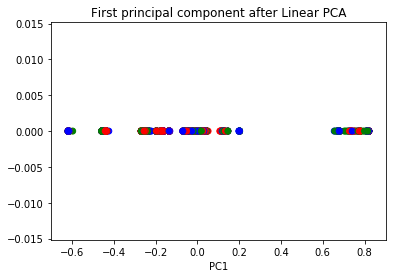

In [44]:
tfidf_model = vectorize_text(text)
tf = tfidf_model.todense()

pca = PCA(n_components=4)
X_pca = pca.fit_transform(tf)

plt.figure()
plt.scatter(X_pca, np.zeros((891, 4)), c='rgb', cmap=plt.cm.rainbow)
plt.title('First principal component after Linear PCA')
plt.xlabel('PC1')
plt.show()

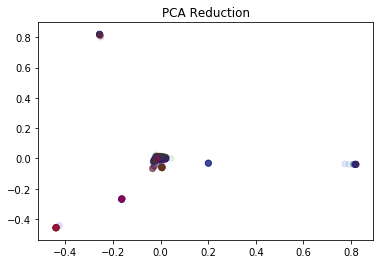

In [45]:
tfidf_model = vectorize_text(text)
tfidf_dense = tfidf_model.todense()

pca = PCA(n_components=4)
data2D = pca.fit_transform(tfidf_dense)

#this array is one dimesional so we plot using
plt.scatter(data2D[:,0], data2D[:,1], c='rgb', alpha=0.1)
plt.title('PCA Reduction')
plt.show() 


## Count Vecotrizer Pickled Model

In [ ]:
vectorizer = CountVectorizer(decode_error="replace")
vec_train = vectorizer.fit_transform(for_model)

#Save vectorizer.vocabulary_
pickle.dump(vectorizer.vocabulary_,open("data/countvec_feature.pkl", "wb"))



In [ ]:
#Load it later
transformer = TfidfTransformer()
loaded_vec = CountVectorizer(decode_error="replace",vocabulary=pickle.load(open("data/countvec_feature.pkl", "rb")))
tfidf = transformer.fit_transform(loaded_vec.fit_transform(for_model))

## VADER Sentiment Scores

In [ ]:
#vader sentiment column ['positivity'] 0 - 1 for chi2score

In [ ]:
tfidf = TfidfVectorizer(stop_words=stopwords.words('english'), ngram_range=(1, 3), lowercase=True)
tfidf_model = tfidf.fit_transform(text)
y = english['positivity']
chi2score = chi2(X_tfidf, y)[0]

%matplotlib inline
plt.figure()
scores = list(zip(tfidf.get_feature_names(), chi2score))
chi2 = sorted(scores, key=lambda x:x[1])
topchi2 = list(zip(*chi2[-20:]))
x = range(len(topchi2[1]))
labels = topchi2[0]
plt.barh(x,topchi2[1], align='center', alpha=0.5)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels)
plt.xlabel('$\chi^2$')
plt.show();

## Truncate Singular Value Decomposition (SVD) aka Latent Semantic Analysis (LSA)

In [ ]:
tfidf_model = vectorize_text(text)

svd = TruncatedSVD(n_components=100, n_iter=7, random_state=42)
clf = svd.fit_transform(tfidf_model) 

#this array is one dimesional so we plot using
plt.scatter(clf[:,0], clf[:,1], c='rgb', alpha=0.1)
plt.title('Truncated SVD Reduction')
plt.show() 



## Word2vec

In [ ]:
from sklearn.manifold import TSNE
from gensim.models import Word2Vec
from bokeh.plotting import figure, show
from bokeh.io import push_notebook, output_notebook
from bokeh.models import ColumnDataSource, LabelSet

model = Word2Vec(sentences=text, workers=4)
X = model[model.wv.vocab]

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
plt.show()

In [ ]:


def interactive_tsne(text_labels, tsne_array):
    '''makes an interactive scatter plot with text labels for each point'''

    # define a dataframe to be used by bokeh context
    bokeh_df = pd.DataFrame(tsne_array, text_labels, columns=['x','y'])
    bokeh_df['text_labels'] = bokeh_df.index

    # interactive controls to include to the plot
    TOOLS="hover, zoom_in, zoom_out, box_zoom, undo, redo, reset, box_select"

    p = figure(tools=TOOLS, plot_width=700, plot_height=700)

    # define data source for the plot
    source = ColumnDataSource(bokeh_df)

    # scatter plot
    p.scatter('x', 'y', source=source, fill_alpha=0.6,
              fill_color="#8724B5",
              line_color=None)

    # text labels
    labels = LabelSet(x='x', y='y', text='text_labels', y_offset=8,
                      text_font_size="8pt", text_color="#555555",
                      source=source, text_align='center')

    p.add_layout(labels)

    # show plot inline
    output_notebook()
    show(p)

In [ ]:
%%javascript
element.interactive_tsne(model.wv.vocab.keys(), X_tsne)

## KMeans

In [ ]:
find_elbow(text)

In [ ]:
vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'), ngram_range=(1, 3), lowercase=True) 
tfidf_model = vectorizer.fit_transform(text)

# less noise without SVD
# svd = TruncatedSVD(n_components=100, n_iter=7, random_state=42)
# clf = svd.fit_transform(tfidf_model) 

kmeans = KMeans(n_clusters=5, n_init = 5, n_jobs = -1)
km = kmeans.fit_transform(tfidf_model)

In [ ]:
words = vectorizer.get_feature_names()
common_words = kmeans.cluster_centers_.argsort()[:,-1:-11:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

In [ ]:
kmeans_df = english
kmeans_df['cluster'] = kmeans.labels_
kmeans_df.head(1)

In [ ]:
#kmeans_df.to_csv('data/kmeans_clusters.csv', encoding='utf-8', index=False)

In [ ]:
#this array is one dimesional so we plot using
plt.scatter(km[:,0], km[:,1], c='rgb', alpha=0.1)
centers2D = kmeans.cluster_centers_

plt.scatter(centers2D[:,0], centers2D[:,1], marker='x', s=200, linewidths=3, c='r')
plt.title('TruncatedSVD + KMeans')
plt.show() 

In [ ]:
svd = TruncatedSVD(n_components=100, n_iter=7, random_state=42)
clf = svd.fit_transform(tfidf_model) 

## LDA

In [ ]:
for c in text:
    tok = word_tokenize(text[1])
    dictionary = corpora.Dictionary([(str(tok).split())])
    corpus = [dictionary.doc2bow(t) for t in ([(str(tok).split())])]

In [ ]:
np.random.seed(seed=44)

tok = word_tokenize(text[1])
dictionary = corpora.Dictionary([(str(tok).split())])
corpus = [dictionary.doc2bow(t) for t in ([(str(tok).split())])]

# number of topics
K=3

# Run LDA model to extract topics
lda = LdaModel(corpus=corpus, id2word=dictionary, num_topics=K, alpha='auto', passes=10)

In [ ]:
lda.show_topics(K, num_words=10, formatted=False)

In [ ]:
vis_data = gensimvis.prepare(lda, corpus, dictionary)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis_data)

## LDA sklearn

In [23]:
vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'), ngram_range=(1, 3), lowercase=True) 
tfidf_model = vectorizer.fit_transform(text)

lda_tfidf = LatentDirichletAllocation(n_components=5, random_state=0)
lda_model = lda_tfidf.fit_transform(tfidf_model)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


In [13]:
pyLDAvis.enable_notebook()

pyLDAvis.sklearn.prepare(lda_tfidf, tfidf_model, vectorizer)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
3      79.215982        1       1 -0.013179  0.000191
0      11.165040        1       2  0.004133  0.003072
1       4.768427        1       3  0.003291 -0.001564
4       4.321115        1       4  0.003121 -0.001138
2       0.529437        1       5  0.002634 -0.000561, topic_info=       Category      Freq                   Term     Total  loglift  logprob
term                                                                        
512940  Default  0.000000                  steve  0.000000  30.0000  30.0000
23377   Default  1.000000               applause  1.000000  29.0000  29.0000
540212  Default  0.000000                 teller  0.000000  28.0000  28.0000
391396  Default  0.000000                   penn  0.000000  27.0000  27.0000
85054   Default  0.000000               cheering  0.000000  26.0000  26.0000
391413  Default  0.000000            penn teller  0.000000  25.0000  25.0000
85059   Default  0.000000      cheering applause  0.000000  24.0000  24.0000
237226  Default  0.000000                  heart  0.000000  23.0000  23.0000
17199   Default  0.000000                 andrew  0.000000  22.0000  22.0000
322482  Default  0.000000                  magic  0.000000  21.0000  21.0000
51258   Default  0.000000               birthday  0.000000  20.0000  20.0000
15216   Default  0.000000                 alyson  0.000000  19.0000  19.0000
257219  Default  0.000000                   inch  0.000000  18.0000  18.0000
147038  Default  0.000000                   doug  0.000000  17.0000  17.0000
259368  Default  0.000000              infection  0.000000  16.0000  16.0000
571788  Default  0.000000                  trick  0.000000  15.0000  15.0000
536163  Default  0.000000                  taryn  0.000000  14.0000  14.0000
626942  Default  2.000000                   york  2.000000  13.0000  13.0000
19878   Default  0.000000                 answer  0.000000  12.0000  12.0000
523462  Default  0.000000                   suit  0.000000  11.0000  11.0000
292810  Default  1.000000               laughter  1.000000  10.0000  10.0000
356160  Default  1.000000                   name  1.000000   9.0000   9.0000
322637  Default  0.000000               magician  0.000000   8.0000   8.0000
73638   Default  0.000000                   card  0.000000   7.0000   7.0000
356709  Default  0.000000         name something  0.000000   6.0000   6.0000
271187  Default  0.000000                  joint  0.000000   5.0000   5.0000
233746  Default  0.000000                 harvey  0.000000   4.0000   4.0000
169308  Default  0.000000                excited  0.000000   3.0000   3.0000
606214  Default  0.000000                  wheel  0.000000   2.0000   2.0000
237361  Default  0.000000            heart heart  0.000000   1.0000   1.0000
...         ...       ...                    ...       ...      ...      ...
326131   Topic5  0.000280         mall need save  0.048349   0.0880 -13.3453
204021   Topic5  0.000279      game game stadium  0.047654   0.1021 -13.3457
544782   Topic5  0.000279   thanksgiving beeping  0.047508   0.1051 -13.3458
600889   Topic5  0.000279   week take additional  0.047127   0.1130 -13.3460
455491   Topic5  0.000279           rolled house  0.048052   0.0939 -13.3456
438355   Topic5  0.000279    rejoin company want  0.047729   0.1005 -13.3458
627603   Topic5  0.000280           younger well  0.051867   0.0182 -13.3449
329461   Topic5  0.000279    married year sudden  0.048088   0.0930 -13.3458
420582   Topic5  0.000279   protein pack protein  0.047340   0.1085 -13.3460
65578    Topic5  0.000279   bullts like somebody  0.047452   0.1061 -13.3460
435040   Topic5  0.000280            reason suit  0.050443   0.0456 -13.3454
159564   Topic5  0.000279  engineer exactly pump  0.047548   0.1040 -13.3461
584846   Topic5  0.000279         vega happening  0.047024   0.1150 -13.3462
555469   Topic5  0.000280            

In [7]:
print("Sparcity: ", ((tfidf_model > 0).sum()/tfidf_model.size)*100, "%")
print("Log Likelihood: ", lda_tfidf.score(tfidf_model))
print("Perplexity: ", lda_tfidf.perplexity(tfidf_model))

Sparcity:  100.0 %
Log Likelihood:  -502107.54887255287
Perplexity:  4067339.2058298644


Perplexity may not be the best measure to evaluate topic models because there is no consideration of the context and semantic associations between words.

## LDA GridSearch

In [14]:
search_params = {'n_components': [3, 5, 8, 10], 'learning_decay': [.5]}

In [15]:
lda = LatentDirichletAllocation()
model = GridSearchCV(lda, param_grid=search_params)
model.fit(tfidf_model)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online'

GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1,
             n_topics=None, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_components': [3, 5, 8, 10], 'learning_decay': [0.5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [16]:
best_lda_model = model.best_estimator_

print("Best Model's Params: ", model.best_params_)
print("Best Log Likelihood Score: ", model.best_score_)
print("Model Perplexity: ", best_lda_model.perplexity(tfidf_model))

Best Model's Params:  {'learning_decay': 0.5, 'n_components': 3}
Best Log Likelihood Score:  -169063.6091528614
Model Perplexity:  1808413.757669866


In [33]:
vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'), ngram_range=(1, 3), lowercase=True) 
tfidf_model = vectorizer.fit_transform(text)

best_lda_model = LatentDirichletAllocation(n_components=3, learning_decay=0.5)
best_lda_model.fit(tfidf_model)

df_topic_keywords = pd.DataFrame(best_lda_model.components_)
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.head()

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


,aaa,aaa information,aaa information aaa,aaa survey,aaa survey survey,aaaaah,aaaaah definitely,aaaaah definitely wrong,aaaahhhh,aaaahhhh gorilla,...,étouffée frank,étouffée frank think,étouffée like,étouffée like gravy,étouffées,étouffées mike,étouffées mike beignet,úçúç,úçúç çúçúc,úçúç çúçúc cúc
0,0.355312,0.344320,0.344321,0.344321,0.344320,0.357554,0.357554,0.357553,0.345154,0.345155,...,0.346010,0.346010,0.346010,0.346010,0.346011,0.346010,0.346010,0.362020,0.362021,0.362021
1,0.333371,0.333355,0.333355,0.333355,0.333355,0.333374,0.333374,0.333373,0.333358,0.333358,...,0.333365,0.333364,0.333365,0.333365,0.333365,0.333365,0.333365,0.333393,0.333393,0.333393
2,0.333371,0.333355,0.333355,0.333355,0.333355,0.333375,0.333374,0.333374,0.333357,0.333358,...,0.333366,0.333366,0.333365,0.333365,0.333365,0.333365,0.333365,0.333393,0.333392,0.333392


In [34]:
# Show top n keywords for each topic

def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
        
    return topic_keywords

In [35]:
topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)     

df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
0,right,know,like,yeah,okay,applause,york,love,steve,laugh,want,well,come,blake,kelly
1,chug,chug chug,chug chug chug,gurkel,talk okay,brother talk,lean back,butterfly,talk letting,talk letting talk,young republican,letting talk,perfectly okay,would okay,junior
2,elton,harry,harvey,kripke,rabbit,bradley,singing,taron,guitar,announcer,flag,harry style,star,cheryl,long time


Text(0.5,1,'LDA/KMeans Topic Clusters via 2 Component SVD')

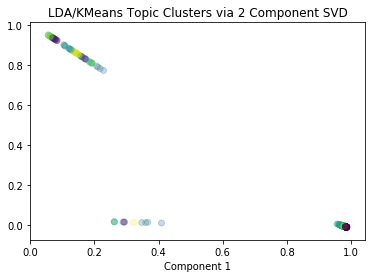

In [40]:
lda_output = best_lda_model.transform(tfidf_model)
clusters = KMeans(n_clusters=15, random_state=100).fit_predict(lda_output)

svd_model = TruncatedSVD(n_components=2)
lda_output_svd = svd_model.fit_transform(lda_output)

plt.scatter(lda_output_svd[:, 0], lda_output_svd[:, 1], c=clusters, alpha=0.25)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("LDA/KMeans Topic Clusters via 2 Component SVD", )